# Homework 4 - Applied ML
## Exercise 1

Our goal for this exercise is to predict the skin color of a soccer player given  his description. We will use a Random Forest Classifier and discuss the importance of each feature of the dataset.

In [1]:
# Standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # for cleaner output

In [2]:
import sklearn.ensemble
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

### Cleaning the Data

In [3]:
df_raw = pd.read_csv('CrowdstormingDataJuly1st.csv')
df_raw.shape

(146028, 28)

First, we discard all the rows which have no data for the columns rater1 and rater2 and then we compute the mean of the raters to obtain a value between 0 and 1 which we define as the skin colour.

In [4]:
df = df_raw.dropna(subset=['rater1', 'rater2'])

In [5]:
df['skin_colour'] = df[['rater1', 'rater2']].mean(axis=1)
df = df.drop(['rater1', 'rater2'], axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


Here are the columns for each dyad, we will keep only the revelent ones for the rest of the exercise. Since we are interested in the characteristics of each player, we drop the columns related to the referee.

In [6]:
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'refNum',
       'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp', 'skin_colour'],
      dtype='object')

Then we group the data by player and we use the operator max() to keep the value with the maximum number of occurences for the categorical values and we add the numerical values such as the number of games.

In [7]:
df_playergr1 = df[['playerShort', 'club', 'leagueCountry',
                   'height', 'weight', 'position', 'skin_colour']].groupby('playerShort').max()
df_playergr2 = df[['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals',
                   'yellowCards', 'yellowReds', 'redCards']].groupby('playerShort').sum()
df_player = pd.concat([df_playergr1, df_playergr2], axis=1)
df_player.head()

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,0.125,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,0.125,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,0.250,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.000,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,0.250,124,41,40,43,1,8,4,2


We can see that they are still some columns with NaN values, we decided to drop the rows which have no weight or height since there are very few of them. We replace the NaN values in the position column by "No Info" so that they will be properly encoded later. 

In [8]:
df_player.isnull().sum()

club               0
leagueCountry      0
height             3
weight            21
position         152
skin_colour        0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
dtype: int64

In [9]:
df_player.position = df_player[['position']].fillna('No Info')
df_player = df_player.dropna(subset=['height', 'weight'])

Here are some plots to have a first look at the possible correlations between the skin color and the others features of the dataframe.

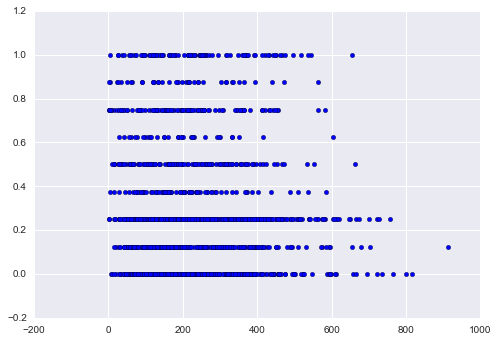

In [10]:
plt.scatter(df_player.games, df_player.skin_colour)

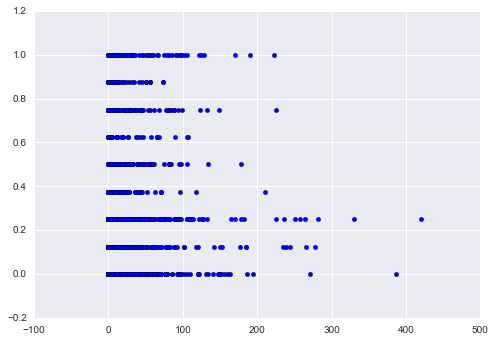

In [11]:
plt.scatter(df_player.goals, df_player.skin_colour)

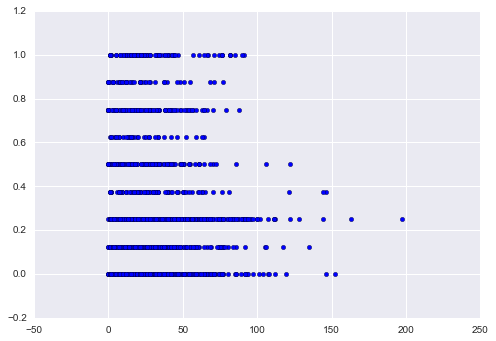

In [12]:
plt.scatter(df_player.yellowCards, df_player.skin_colour)

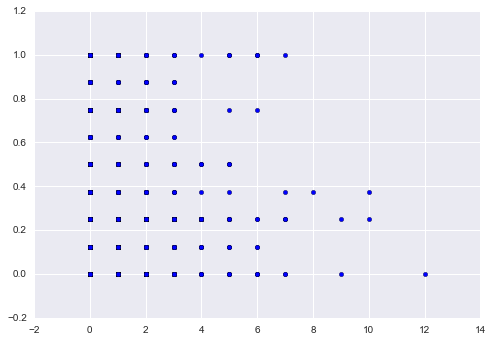

In [13]:
plt.scatter(df_player.yellowReds, df_player.skin_colour)

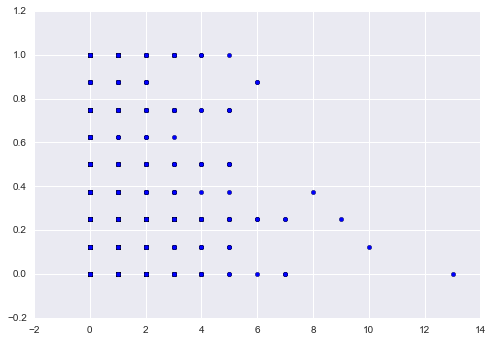

In [14]:
plt.scatter(df_player.redCards, df_player.skin_colour)

We can not see any obvious correlation between the values but we can notice that there are much more players with a fairer skin tone and on this next plot we can clearly see that the distribution is skewed.

(array([ 418.,  225.,  466.,   77.,    0.,  115.,   33.,  100.,   40.,   90.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

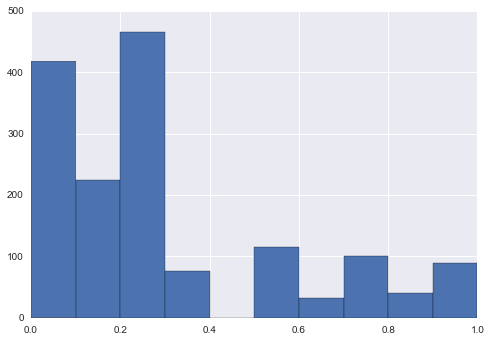

In [15]:
plt.hist(df_player.skin_colour)

## Classification models

We decided to use 3 classifications models. 
- The first one is a binary model where all skin_colour values below 0.5 are considered white and all above black. The players with skin_colour value exactly 0.5 are dropped.
- The second one is a ternary model. The players with skin_colour values in [0, 0.25] are in the first category, the second catergory is composed of the players with skin_colour values in ]0.25, 0.75[ and finally the players with skin_colour values greater or equal to 0.75 are in the third category.  
- The last model consider the 9 category produced by the mean of the two raters.

In [16]:
df_player_bin = df_player.copy()
df_player_ter = df_player.copy()
df_player_all = df_player.copy()

In [17]:
# Binary Classification (removing 0.5 and sorting the values)
df_player_bin = df_player_bin[df_player_bin['skin_colour'] != 0.5]
df_player_bin.loc[df_player_bin.skin_colour < 0.5, 'skin_colour'] = 0
df_player_bin.loc[df_player_bin.skin_colour > 0.5, 'skin_colour'] = 1
df_player_bin.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,0.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,0.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,0.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,0.0,124,41,40,43,1,8,4,2


In [18]:
# Ternary Classification (3 groups of 3 values)
df_player_ter.loc[df_player_ter.skin_colour <= 0.25, 'skin_colour'] = -1
df_player_ter.loc[df_player_ter.skin_colour >= 0.75, 'skin_colour'] = 1
df_player_ter.loc[(df_player_ter.skin_colour > 0.25) & (df_player_ter.skin_colour < 0.75), 'skin_colour'] = 0
df_player_ter.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,-1.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,-1.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,-1.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,-1.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,-1.0,124,41,40,43,1,8,4,2


In [19]:
df_player_all.skin_colour = df_player_all.skin_colour * 8
df_player_all.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,1.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,1.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,2.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,2.0,124,41,40,43,1,8,4,2


Then we drop the skin_colour column to obtain an unlabelled dataframe almost ready to be trained.

In [20]:
df_ml_bin = df_player_bin.drop('skin_colour', axis=1)
df_ml = df_player.drop('skin_colour', axis=1)

## Encoding the categorical values

The categorical values must be transformed into numbers in order to be fitted to the Random Forest. Our first idea was to use a simple Label encoder, which assign a numerical value to the elements of a given column.

In [21]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(df_ml_bin['club'])
df_ml_bin['club'] = le.transform(df_ml_bin['club'])
le.fit(df_ml_bin['leagueCountry'])
df_ml_bin['leagueCountry'] = le.transform(df_ml_bin['leagueCountry'])
le.fit(df_ml_bin['position'])
df_ml_bin['position'] = le.transform(df_ml_bin['position'])
df_ml_bin.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,
aaron-hughes,32,0,182.0,71.0,1,654,247,179,228,9,19,0,0
aaron-hunt,87,2,183.0,73.0,0,336,141,73,122,62,42,0,1
aaron-lennon,79,0,165.0,63.0,11,412,200,97,115,31,11,0,0
aaron-ramsey,6,0,178.0,76.0,3,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,47,1,180.0,73.0,1,124,41,40,43,1,8,4,2


Then we split the data into train/test sets with a ratio of 20%, apply a simple random forest classifier to have a basic idea of the accuracy.

In [22]:
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(df_ml_bin, df_player_bin.skin_colour, test_size=0.2, random_state = 0)

rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(x_train_bin, y_train_bin)
rfc.predict(x_test_bin)
rfc.score(x_test_bin, y_test_bin)

0.86206896551724133

The accuracy of this simple model seems good but we will come back to that later. We can see below that the importance of each feature. Like the previous graphs, we can not deduce anything from a particular feature. 

In [23]:
ind = np.argsort(rfc.feature_importances_)[::-1]
for feature in range(x_train_bin.shape[1]):
    print("Feature : " + str(x_train_bin.columns[ind[feature]]) + " ->  " +  str(rfc.feature_importances_[ind[feature]]))

Feature : goals ->  0.101333451562
Feature : games ->  0.098170934557
Feature : victories ->  0.0897537116847
Feature : club ->  0.0876958218616
Feature : defeats ->  0.0876295110594
Feature : leagueCountry ->  0.086387799162
Feature : ties ->  0.0861200674832
Feature : yellowCards ->  0.0827216033662
Feature : weight ->  0.0800887995986
Feature : height ->  0.076342655039
Feature : position ->  0.0602083441877
Feature : yellowReds ->  0.0338105111303
Feature : redCards ->  0.0297367893077


## Model Selection

We have seen above that with this simple model, it seems that we can obtain a pretty good accuracy. But some details need to be taken into account. 

First of all, the encoder can be improved. The assignation of numerical values to the field may induce a relation of order to the Random Forest Classifier. For example, if the position "Right Midfielder" is assigned to 0 and "Attacking Midfielder" to 1, the Random Forest must have a criterion such that the player with position lesser than 2 are more likely to be white. Thus, we decided to use the encoder DictVectorizer which vectorize the features preventing this order relation problem.

Then, we have also decided to scale the data, thus the model should be a bit more robust but as a tradeoff, we loose the interpretability of the features, hence the small analysis of the features above.

In [24]:
# A small function which encodes a training and a testing set with the DictVectorizer
def encode_df(df_tr, df_te):
    encoder = DictVectorizer(sparse=False)
    df_train = df_tr.convert_objects(convert_numeric=True)
    df_test = df_te.convert_objects(convert_numeric=True)

    df_train = encoder.fit_transform(df_train.to_dict(orient='records'))
    df_test = encoder.fit_transform(df_test.to_dict(orient='records'))

    return df_train, df_test 

In [25]:
df_ml_bin = df_player_bin.drop('skin_colour', axis=1)
df_ml = df_player.drop('skin_colour', axis=1)
# Building the training sets and testing sets
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(df_ml_bin, df_player_bin.skin_colour, test_size=0.2, random_state = 0)
x_train_ter, x_test_ter, y_train_ter, y_test_ter = train_test_split(df_ml, df_player_ter.skin_colour, test_size=0.2, random_state = 0)
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(df_ml, df_player_all.skin_colour, test_size=0.2, random_state = 0)

We use our function to transform the categorical data with DictVectorize.

In [26]:
df_ml_bin_tr, df_ml_bin_te = encode_df(x_train_bin, x_test_bin)
df_ml_ter_tr, df_ml_bin_te = encode_df(x_train_ter, x_test_ter)
df_ml_all_tr, df_ml_all_te = encode_df(x_train_all, x_test_all)

Finally, the last operation before the training is the scaling of the data.

In [27]:
ml_scaled_bin = preprocessing.scale(df_ml_bin_tr)
df_ml_scaled_bin = pd.DataFrame(ml_scaled_bin)

ml_scaled_ter = preprocessing.scale(df_ml_ter_tr)
df_ml_scaled_ter = pd.DataFrame(ml_scaled_ter)

ml_scaled_all = preprocessing.scale(df_ml_all_tr)
df_ml_scaled_all = pd.DataFrame(ml_scaled_all)

To obtain the best model, we tried several parameters and we used a gridSearch to get the best ones using 5 cross-validations.

In [28]:
param_grid = [
    {'n_estimators': [10,15,20,25,30,40,50,75,100, 125], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}
]

In [29]:
rfc_bin = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
rfc_ter = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
rfc_all = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

rfc_bin.fit(df_ml_scaled_bin, y_train_bin)
rfc_ter.fit(df_ml_scaled_ter, y_train_ter)
rfc_all.fit(df_ml_scaled_all, y_train_all)

print('Binary Best Score : ' + str(rfc_bin.best_score_))
print('Ternary Best Score : ' + str(rfc_ter.best_score_))
print('All params Best Score : ' + str(rfc_all.best_score_))

print('Binary Best Parameters : ' + str(rfc_bin.best_params_))
print('Ternary Best Parameters : ' + str(rfc_ter.best_params_))
print('All params Best Parameters : ' + str(rfc_all.best_params_))

Binary Best Score : 0.823986194996
Ternary Best Score : 0.716227018385
All params Best Score : 0.334132693845
Binary Best Parameters : {'max_features': 'log2', 'n_estimators': 20, 'criterion': 'gini'}
Ternary Best Parameters : {'max_features': 'sqrt', 'n_estimators': 75, 'criterion': 'entropy'}
All params Best Parameters : {'max_features': 'log2', 'n_estimators': 125, 'criterion': 'gini'}


We can see that the parameters for the best Random Forest Classifiers vary depending the numbers of classes. The scores above are way too large and if we take a closer look at the data, we have already noticed that the distribution is skewed. In this case, it is better to use a f1 scoring function which penalizes more the false positives and the true negatives.

In [30]:
rfc_bin = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1')
rfc_bin.fit(df_ml_scaled_bin, y_train_bin)
print('Binary Best Score with f1 Scoring : ' + str(rfc_bin.best_score_))

Binary Best Score with f1 Scoring : 0.221880211146
